In [1]:
# General imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
# Image processing imports
from scipy import misc
from skimage.transform import resize
from skimage.filters import threshold_otsu

In [3]:
# Machine learning imports
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Initial test - RNN + single image

Train an RNN to indentify segementation training on a single image.  Target segementations are generated with the pixel sum heuristic; images are resized to 100 pixel height, a column that sums to < 10 is considered a valid segmentation for training.

In [4]:
dataPath = '/Users/dwright/dev/gym-zooniverse/gym_zooniverse/envs/assets/' # path to image data

In [5]:
# load the example image for this test
image = misc.imread(os.path.join(dataPath+'a01/a01-000u/a01-000u-00-01.png'))
h, w = image.shape
image = resize(image, (100, w)) # resize to 100 pixel height, preserving original width
thresh = threshold_otsu(image)  # calculate threshold to cast the image as a binary
image = np.asarray(image < thresh, dtype='int') # cast to binary image

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


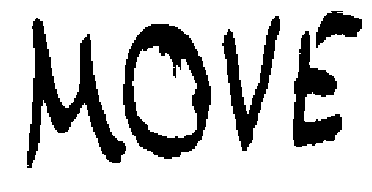

In [6]:
# visualise the image
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

In [7]:
# generate the valid segmentations
y = np.zeros((image.shape[1]))
for i in range(image.shape[1]):
  y[i] += np.sum(image[:,i]) <= 10

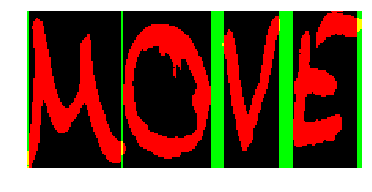

In [8]:
# plot the segmentations
img = np.zeros((image.shape[0], image.shape[1], 3))
img[:,:,0] += image
for i in range(len(y)):
  img[:,i,1] += y[i]
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
# build a RNN to train on this image
model = Sequential()
model.add(LSTM(256, input_shape=(None, 100)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [10]:
# train the model
model.fit(image.T[:,np.newaxis,:], np_utils.to_categorical(y, 2), epochs=5, batch_size=1, verbose=1)

Epoch 1/5
213/213 [==============================] - 3s - loss: 0.1456 - acc: 0.9014           

In [11]:
# get the predicted segmentations
pred = np.argmax(model.predict(image.T[:,np.newaxis,:]), axis=1)

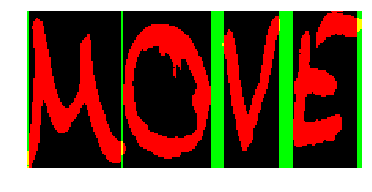

In [12]:
# visualise the predicted segmentations
img = np.zeros((image.shape[0], image.shape[1], 3))
img[:,:,0] += image
for i in range(len(pred)):
  img[:,i,1] += pred[i]
plt.imshow(img)
plt.axis('off')
plt.show()

# Initial test - Evolution Strategy + single image

In this case rather than using heuristics to determine a set of valid segmentation columns and trian using back prop., we will use human input and evolution strategies to train the RNN.

In [24]:
# build a model similar to above, but smaller for the time being.
model = Sequential()
model.add(LSTM(8, input_shape=(None, 100)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 3,506.0
Trainable params: 3,506
Non-trainable params: 0.0
_________________________________________________________________


In [27]:
# get the weights from this network (it is currently only randomly initialised)
w = model.get_weights()

In [39]:
# define some parameters for the evolution strategy
npop = 10      # population size
sigma = 0.1    # noise standard deviation
alpha = 0.001  # learning rate

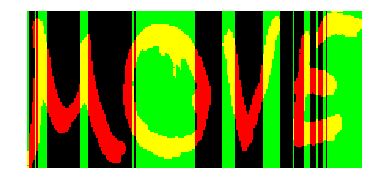

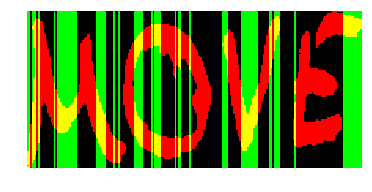

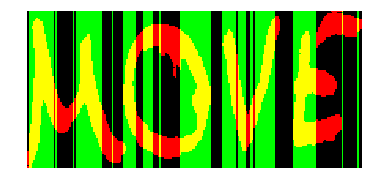

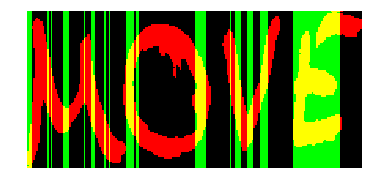

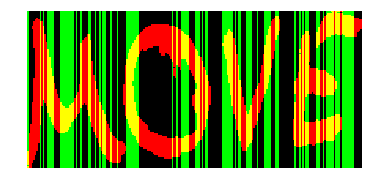

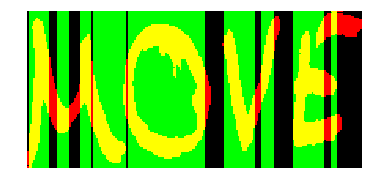

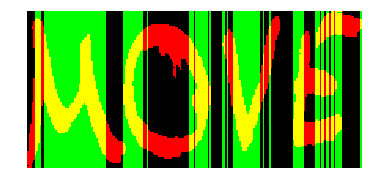

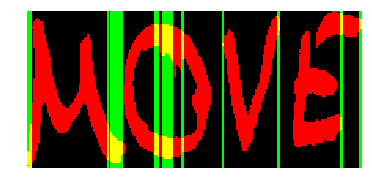

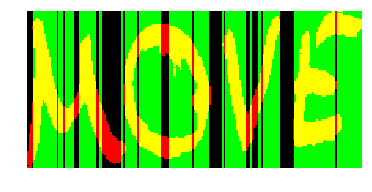

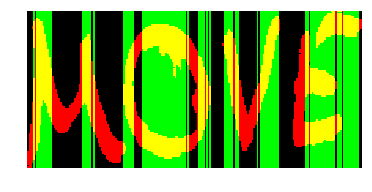

In [40]:
# perturb the weights of the RNN and make a prediction
for i in range(npop):
  # clone the original model
  model_copy = Sequential()
  model_copy.add(LSTM(8, input_shape=(None, 100)))
  model_copy.add(Dense(2, activation='softmax'))
  model_copy.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  w_try = w[:]
  for j in range(len(w)):
    w_try[j] += sigma * np.random.randn(w[j].shape)
  model_copy.set_weights(w_try)
  pred = np.argmax(model_copy.predict(image.T[:,np.newaxis,:]), axis=1)
  img = np.zeros((image.shape[0], image.shape[1], 3))
  img[:,:,0] += image
  for i in range(len(pred)):
    img[:,i,1] += pred[i]
  plt.imshow(img)
  plt.axis('off')
  plt.show()